# AKT-inhibitor phosphoproteomics

## Setup

In [ ]:
!pip install statsmodels git+https://github.com/sky1ove/katlas.git -q

In [ ]:
!pip install statsmodels -q

In [ ]:
from katlas.core import *
import pandas as pd
from scipy.stats import ttest_rel
from tqdm import tqdm
import numpy as np 
from statsmodels.stats.multitest import multipletests
from katlas.core import *
from fastcore.basics import partial
from functools import reduce

In [ ]:
pd.set_option('display.precision', 15)

In [ ]:
def get_ttest(df, col1, col2, alpha=0.05, correction_method='fdr_bh',paired=False):
    """
    Performs t-tests and calculates log2 fold change between two groups in a DataFrame.
    NaN p-values are excluded from the multiple testing correction.

    Parameters:
    df (DataFrame): DataFrame with genes as index and patients as columns.
    col1, col2 (list): Column names for the two groups to compare.
    alpha (float): Significance level for multiple testing correction.
    correction_method (str): Method for multiple testing correction.

    Returns:
    DataFrame: Results including log2FC, p-values, adjusted p-values, and significance.
    """
    group1 = df[col1]
    group2 = df[col2]

    # Compute median values for each gene in both groups
    med1 = group1.median(axis=1)
    med2 = group2.median(axis=1)

    # Compute log2 fold change
    FCs = med2 - med1

    # Perform t-tests and handle NaN p-values
    if paired:
        t_results = [ttest_rel(group1.loc[gene], group2.loc[gene], nan_policy='omit') for gene in tqdm(df.index, desc="Computing t-tests")]
    else:
        t_results = [ttest_ind(group1.loc[gene], group2.loc[gene], nan_policy='omit') for gene in tqdm(df.index, desc="Computing t-tests")]

    
    p_values = [result.pvalue if result.pvalue is not np.nan else np.nan for result in t_results]

    # Exclude NaN p-values before multiple testing correction
    valid_p_values = np.array(p_values)
    valid_p_values = valid_p_values[~np.isnan(valid_p_values)]
    
    # Adjust for multiple testing on valid p-values only
    reject, pvals_corrected, _, _ = multipletests(valid_p_values, alpha=alpha, method=correction_method)
    
    # Create a full list of corrected p-values including NaNs for the excluded genes
    full_pvals_corrected = np.empty_like(p_values)
    full_pvals_corrected[:] = np.nan
    np.place(full_pvals_corrected, ~np.isnan(p_values), pvals_corrected)
    
    # Adjust the significance accordingly
    full_reject = np.zeros_like(p_values, dtype=bool)
    np.place(full_reject, ~np.isnan(p_values), reject)

    # Create DataFrame with results
    results = pd.DataFrame({
        'log2FC_median': FCs,
        'p_value': p_values,
        'p_adj': full_pvals_corrected,
        'significant': full_reject
    })

    results['p_value'] = results['p_value'].astype(float)
    
    return results

## Data

In [ ]:
df = pd.read_csv('AKT_inhibitor.csv')

In [ ]:
df

,gene_site,site_seq,Control_R1,Control_R2,Control_R3,Control_R4,AZD5363_R1,AZD5363_R2,AZD5363_R3,AZD5363_R4,...,GSK690693_R3,GSK690693_R4,Ipatasertib_R1,Ipatasertib_R2,Ipatasertib_R3,Ipatasertib_R4,MK-2206_R1,MK-2206_R2,MK-2206_R3,MK-2206_R4
0,AAK1_S637,AGHRRILsDVtHsAV,14.167260000000001,13.791940000000000,13.888430000000000,13.991310000000000,14.581049999999999,14.802630000000001,14.723060000000000,14.857880000000000,...,14.47591,14.810269999999999,14.541550000000001,14.598560000000001,14.669480000000000,14.267690000000000,14.500560000000000,14.700110000000000,14.642170000000000,14.394790000000000
1,ABCF1_S105,MERLKKLsVPtsDEE,14.184260000000000,14.422390000000000,14.320520000000000,14.310689999999999,14.905970000000000,15.157950000000000,14.848050000000001,14.968950000000000,...,14.82788,14.924620000000001,14.888140000000000,15.019850000000000,14.857740000000000,14.809049999999999,14.915050000000001,14.815270000000000,15.067920000000001,14.526149999999999
2,ACIN1_S208,HSPRKSSsIsEEKGD,15.956730000000000,15.791060000000000,NaN,15.961280000000000,14.763690000000000,14.926340000000000,NaN,14.933990000000000,...,NaN,14.728800000000000,15.004510000000000,14.969420000000000,NaN,14.797020000000000,14.923180000000000,15.012650000000001,NaN,15.046220000000000
3,ACIN1_S216,IsEEKGDsDDEKPRK,17.457689999999999,16.997420000000002,17.373349999999999,17.434950000000001,16.252500000000001,16.341049999999999,16.316970000000001,16.411560000000001,...,16.38372,16.193570000000001,16.486070000000002,16.445869999999999,16.275169999999999,16.242329999999999,16.405529999999999,16.500750000000000,16.558160000000001,16.533030000000000
4,ACIN1_S240,QARAAkLsEGsQPAE,13.211040000000001,13.129730000000000,13.565530000000001,13.572440000000000,12.127129999999999,12.011320000000000,12.125540000000001,11.806080000000000,...,12.09775,12.322410000000000,11.838360000000000,12.090270000000000,12.027799999999999,11.561370000000000,12.093400000000001,12.152469999999999,12.159110000000000,11.888489999999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10895,ZYX_S308,ALsAGtGsPQPPsFt,11.331410000000000,11.552250000000001,11.535660000000000,NaN,11.861490000000000,11.590350000000001,11.684360000000000,NaN,...,11.48827,NaN,11.241320000000000,11.528520000000000,11.424130000000000,NaN,11.563599999999999,11.414809999999999,11.554449999999999,NaN
10896,ZYX_S344,QNQNQVrsPGAPGPL,16.165450000000000,16.694350000000000,16.624890000000001,16.640699999999999,16.674939999999999,16.860610000000001,16.820910000000001,16.760439999999999,...,16.58822,16.623080000000002,16.681480000000001,16.605000000000000,16.669180000000001,16.572299999999998,16.681220000000000,16.515260000000001,16.638909999999999,16.519490000000001
10897,ZZEF1_S2443,EEVERPVssPGDPEQ,14.662950000000000,14.461040000000001,14.543749999999999,NaN,14.356339999999999,14.548249999999999,14.445140000000000,NaN,...,14.50673,NaN,14.469010000000001,14.419820000000000,14.443940000000000,NaN,14.484690000000001,14.491320000000000,14.548760000000000,NaN
10898,ZZEF1_S2444,EVERPVssPGDPEQK,15.497130000000000,15.515750000000001,15.574990000000000,15.600479999999999,15.547800000000001,15.636749999999999,15.514320000000000,15.500999999999999,...,15.58136,15.607870000000000,15.518500000000000,15.604170000000000,15.527830000000000,15.421749999999999,15.555400000000001,15.553260000000000,15.601540000000000,15.483670000000000


## Get statistics

In [ ]:
ctrl = df.columns[df.columns.str.contains('Control')]

In [ ]:
df.columns

Index(['gene_site', 'site_seq', 'Control_R1', 'Control_R2', 'Control_R3',
       'Control_R4', 'AZD5363_R1', 'AZD5363_R2', 'AZD5363_R3', 'AZD5363_R4',
       'GSK2110183_R1', 'GSK2110183_R2', 'GSK2110183_R3', 'GSK2110183_R4',
       'GSK690693_R1', 'GSK690693_R2', 'GSK690693_R3', 'GSK690693_R4',
       'Ipatasertib_R1', 'Ipatasertib_R2', 'Ipatasertib_R3', 'Ipatasertib_R4',
       'MK-2206_R1', 'MK-2206_R2', 'MK-2206_R3', 'MK-2206_R4'],
      dtype='object')

In [ ]:
AZD = df.columns[df.columns.str.contains('AZD5363')]
GSK = df.columns[df.columns.str.contains('GSK2110183')]
ipa = df.columns[df.columns.str.contains('Ipatasertib')]
MK = df.columns[df.columns.str.contains('MK')]

In [ ]:
azd = get_ttest(df,ctrl, AZD,paired=True)

Computing t-tests: 100%|██████████| 10900/10900 [00:02<00:00, 4110.44it/s]
/tmp/ipykernel_87/3198989361.py:35: UserWarning: Warning: converting a masked element to nan.
  valid_p_values = np.array(p_values)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/tmp/ipykernel_87/3198989361.py:44: UserWarning: Warning: converting a masked element to nan.
  np.place(full_pvals_corrected, ~np.isnan(p_values), pvals_corrected)
/tmp/ipykernel_87/3198989361.py:48: UserWarning: Warning: converting a masked element to nan.
  np.place(full_reject, ~np.isnan(p_values), reject)
/usr/local/lib/python3.9/dist-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [ ]:
info = df.iloc[:,:2]

In [ ]:
azd = pd.concat([info,azd],axis=1)

In [ ]:
def convert_p(r,p_col,FC_col):
    log10 = -np.log10(r[p_col])
    return -log10 if r[FC_col]<0 else log10

In [ ]:
azd['logP'] = azd.apply(convert_p,axis=1,args=('p_value','log2FC_median'))

In [ ]:
def preprocess_seq(seq):
    # Convert non-sty to capital
    seq2 = ''.join([char.upper() if char not in ['s', 't', 'y'] else char for char in seq])
    
    # Convert rare amino acids to "_"
    allowed_chars = set('PGACSTVILMFYWHKRQNDEsty')  # Corrected to set of individual characters
    
    seq3 = ''.join(char if char in allowed_chars else '_' for char in seq2)
    
    return seq3

In [ ]:
azd=azd.dropna(subset='site_seq')

In [ ]:
azd['site_seq2'] = azd.site_seq.str.split(';')

azd = azd.explode('site_seq2').reset_index(drop=True)

In [ ]:
azd['site_seq3'] = azd['site_seq2'].apply(preprocess_seq)

In [ ]:
azd['len'] = azd.site_seq3.str.len()

In [ ]:
azd.sort_values('len')

,gene_site,site_seq,log2FC_median,p_value,p_adj,significant,logP,site_seq2,site_seq3,len
0,AAK1_S637,AGHRRILsDVtHsAV,0.822975000000001,0.008906484793829,0.140264264860036,False,2.050293669236857,AGHRRILsDVtHsAV,AGHRRILsDVtHsAV,15
7285,PIK3C2A_S259,kVSNLQVsPkSEDIS,0.208475000000000,0.038846230740454,0.232669123279732,False,1.410651114521674,kVSNLQVsPkSEDIS,KVSNLQVsPKSEDIS,15
7286,PIK3C2B_S155,EGSCKKLsPPPLPPR,0.088184999999999,0.190927344983904,0.434117714507528,False,0.719131866655360,EGSCKKLsPPPLPPR,EGSCKKLsPPPLPPR,15
7287,PIKFYVE_S1549,DAsPRNIsPGLQNGE,-0.034550000000001,0.664289112521403,0.792059381647510,False,-0.177642865442877,DAsPRNIsPGLQNGE,DAsPRNIsPGLQNGE,15
7288,PIKFYVE_S307,PARNRsAsItNLsLD,-0.158529999999999,0.798614583516688,0.880201512681016,False,-0.097662763409155,PARNRsAsItNLsLD,PARNRsAsItNLsLD,15
...,...,...,...,...,...,...,...,...,...,...
3648,DAB2IP_S978,ssssKGDsPELKPRA,0.052320000000002,0.986867769424062,0.992422713959899,False,0.005741034621776,ssssKGDsPELKPRA,ssssKGDsPELKPRA,15
3649,DAB2IP_S995,KQGPsPVsPNALDRT,0.102135000000001,0.103440867506425,0.336507037040304,False,0.985307845903440,KQGPsPVsPNALDRT,KQGPsPVsPNALDRT,15
3650,DAPK2_S349,EDLRNCEsDTEEDIA,0.063565000000001,0.324004421852016,0.547102601385693,False,0.489449062716765,EDLRNCEsDTEEDIA,EDLRNCEsDTEEDIA,15
3642,CXXC1_S224,KyFPssLsPVtPSES,0.079360000000001,0.221099567436877,0.461749263627937,False,0.655412107081897,KyFPssLsPVtPSES,KyFPssLsPVtPSES,15


## Get kinase score

In [ ]:
ref = Data.get_ks()

In [ ]:
out = predict_kinase_df(azd,ref,seq_col='site_seq3')

according to the ref 
will calculate position: [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 289/289 [00:13<00:00, 21.77it/s]


In [ ]:
out

kinase,SRC,EPHA3,FES,NTRK3,ALK,EPHA8,ABL1,FLT3,EPHB2,FYN,...,MEK5,PKN2,MAP2K7,MRCKB,HIPK3,CDK8,BUB1,MEKK3,MAP2K3,GRK1
0,0.787087909052587,0.844928955692924,0.829329660904428,0.901119099726417,0.865012137386972,0.790062918671220,0.812453772837748,0.752177754870816,0.872658087067716,0.758640731187485,...,1.039439374185137,1.769209480029431,1.524083011583012,1.703712915524842,1.924074074074074,1.501878395512676,1.229469901168014,1.092700700241794,1.322488494499726,1.625091367442773
1,0.901992516556783,1.026890221436848,0.945393536207309,1.051161905372008,1.019700394376175,0.979838683441978,0.893978266033341,0.956286071038669,0.986915274042208,0.940737227477762,...,1.249696533740952,1.818621197086599,1.562302562302562,1.665273144286906,1.879292929292929,1.690213366249339,1.475202156334232,1.258251060685738,1.566942226099358,1.907879542971050
2,0.795744136246873,0.821404997122203,0.787462263603269,0.871191361970226,0.822778688790102,0.787080641478172,0.759519017898600,0.756886401864316,0.778287137809018,0.745599961252301,...,1.209873768026895,1.949592623343661,1.408817421317421,1.601571249851066,1.659427609427609,1.493858477970628,1.202246181491464,1.115349365516879,1.255307990186861,1.843296387586954
3,1.037579904571575,1.160552500305802,1.070433900901407,1.074069711742348,1.050878055574909,1.163237506499675,1.074529704422151,1.067057449020222,1.057761668559765,1.120911229636815,...,1.244651251080240,2.176450456653369,1.616197203697204,1.492620338377219,1.561111111111111,1.698570840785618,1.513566936208446,1.422920536902788,1.292086514081867,2.072632129861716
4,0.955955516855791,0.999116477534104,0.994164022653474,1.048670060934176,1.014800684912740,0.980899891223298,0.955793116932717,0.905698551246392,1.002189151460885,0.947508150890758,...,1.463308056966736,1.689333279331457,1.561331461331461,1.614404861193852,1.826262626262626,1.717633574325516,1.448787061994609,1.382853634284924,1.484787393253844,1.984093107986404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10932,0.668365369776244,0.669135149050542,0.647510812901435,0.773754261240579,0.671090070618287,0.633847971405834,0.789125983753830,0.747963207182034,0.676386558430046,0.649766185061255,...,1.174888978804817,1.638841524742985,1.930459517959518,1.066673120457524,2.235016835016835,1.661089419015711,1.332884097035041,1.282807586539966,1.524579571608893,1.431894556160301
10933,0.775691250439108,0.745720067809916,0.781352988310946,0.800358127490397,0.756543685428098,0.756507476106530,0.807929823914675,0.751723587926779,0.757029802975715,0.749858394350335,...,1.251879492674350,1.445401402698744,1.670729495729496,1.243607768378411,1.950841750841751,1.681481388182146,1.295327942497754,1.172267172901888,1.305334290180543,1.427465026403894
10934,0.986172458054747,0.994128079615470,0.955168062468897,0.991066729273296,0.952760790636024,0.953900731785222,1.065695183135500,1.016729643675535,0.950108532667593,1.105235657756586,...,1.089485081448845,1.766447284043120,1.731225868725868,1.565361015131657,1.988552188552188,1.973233913561898,1.616981132075472,1.364459220270751,1.402011682274275,1.921784765581443
10935,0.900358623904648,0.897714559167551,0.891259110591760,0.953051766010911,0.907555109524297,0.851914116606613,0.900657947286891,0.896748554164530,0.895583586097535,0.867904776591242,...,1.490774875491416,1.689876673214394,1.957811220311221,1.629252055284165,2.166835016835016,2.019678229253260,1.474752920035939,1.325921074513110,1.521478528418674,1.726615858851289


## Get report

In [ ]:
azd.site_seq.str[7].value_counts()

s    9757
t    1097
y      70
S       7
T       4
Y       2
Name: site_seq, dtype: int64

In [ ]:
azd['acceptor'] = azd.site_seq.str[7]

### Gene analysis

In [ ]:
azd['gene'] = azd.gene_site.str.split('_').str[0]

In [ ]:
def get_max(x):
    x = x.dropna().sort_values().values
    return x[0] if abs(x[0])>abs(x[-1]) else x[-1]

In [ ]:
azd_gene = azd.groupby('gene').\
agg({'logP':get_max,'gene_site':'count'}).reset_index().sort_values('logP',ascending=False)

In [ ]:
azd_gene['gene'] = azd_gene['gene'].str.split(';')

In [ ]:
azd_gene = azd_gene.explode('gene')

In [ ]:
azd_gene.sort_values('logP')

,gene,logP,gene_site
75,AKT1S1,-5.261993085200011,16
617,CXorf23,-5.119545591858334,2
2956,ZC3H13,-4.848553306466952,37
1887,PLEKHF2,-4.845626019000024,2
2947,ZBTB21,-4.826680128315477,14
...,...,...,...
1627,NEDD4L,4.195353987943070,13
222,BAHD1,4.325462890351067,4
1534,MRGBP,4.358231109938034,5
2055,PXN,4.583294485164098,19


In [ ]:
# azd_gene.query('logP>1.3 or logP<-1.3').to_csv('AKT_pthway.csv')

### Kinase analysis

In [ ]:
info = Data.get_kinase_info_full().rename(columns={'ID_HGNC':'gene'}).query('pseudo==0')

In [ ]:
azd_kinase = azd_gene.merge(info)

In [ ]:
azd_kinase.sort_values('logP')

,gene,logP,gene_site,kinase,ID_coral,uniprot,group,family,subfamily_coral,subfamily,...,range,human_uniprot_sequence,full_sequence_paper,sequence,category,category_big,cluster,length,kinasecom_domain,hdbscan
177,RPS6KB1,-4.189142168890185,4,P70S6K,p70S6K,P23443,AGC,RSK,RSKp70,RSKp70,...,aa1-421,MRRRRRRDGFYPAPDFRDREAEDMAGVFDIDLDQPEDAGSEDELEE...,MRRRRRRDGFYPAPDFRDREAEDMAGVFDIDLDQPEDAGSEDELEE...,MRRRRRRDGFYPAPDFRDREAEDMAGVFDIDLDQPEDAGSEDELEE...,S6K/RSK,basophilic,7.0,421,FELLRVLGKGGYGKVFQVRKVTGANTGKIFAMKVLKKAMIVRNAKD...,6.0
176,SRPK2,-2.853706040909945,8,SRPK2,SRPK2,P78362,CMGC,SRPK,None,SRPK,...,Full length,MSVNSEKSSSSERPEPQQKAPLVPPPPPPPPPPPPPLPDPTPPEPE...,MSVNSEKSSSSERPEPQQKAPLVPPPPPPPPPPPPPLPDPTPPEPE...,MSVNSEKSSSSERPEPQQKAPLVPPPPPPPPPPPPPLPDPTPPEPE...,SRPK/CLK,pro-directed,6.0,688,YHVIRKLGWGHFSTVWLCWDMQGKRFVAMKVVKSAQHYTETALDEI...,6.0
175,ULK1,-2.780005814723849,9,ULK1,ULK1,O75385,Other,ULK,None,ULK,...,aa1-649,MEPGRGGTETVGKFEFSRKDLIGHGAFAVVFKGRHREKHDLEVAVK...,MEPGRGGTETVGKFEFSRKDLIGHGAFAVVFKGRHREKHDLEVAVK...,MEPGRGGTETVGKFEFSRKDLIGHGAFAVVFKGRHREKHDLEVAVK...,ULK/TTBK,ULK/TTBK,22.0,649,FSRKDLIGHGAFAVVFKGRHREKHDLEVAVKCINKKNLAKSQTLLG...,3.0
106,GSK3B,-2.743578046576185,2,GSK3B,GSK3B,P49841,CMGC,GSK,None,GSK,...,Full length,MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQ...,MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQ...,MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQ...,GSK3,acidophilic,12.0,420,YTDTKVIGNGSFGVVYQAKLCDSGELVAIKKVLQDKRFKNRELQIM...,3.0
174,CHEK1,-2.678193238143057,2,CHK1,CHK1,O14757,CAMK,CAMKL,CHK1,CHK1,...,Full length,MAVPFVEDWDLVQTLGEGAYGEVQLAVNRVTEEAVAVKIVDMKRAV...,MAVPFVEDWDLVQTLGEGAYGEVQLAVNRVTEEAVAVKIVDMKRAV...,MAVPFVEDWDLVQTLGEGAYGEVQLAVNRVTEEAVAVKIVDMKRAV...,PRKD/MAPKAPK,basophilic,15.0,476,WDLVQTLGEGAYGEVQLAVNRVTEEAVAVKIVDMKRAVDCPENIKK...,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,PBK,2.832017157780276,3,PBK,PBK,Q96KB5,Other,TOPK,None,TOPK,...,Full length,MEGISNFKTPSKLSEKKKSVLCSTPTINIPASPFMQKLGFGTGVNV...,MEGISNFKTPSKLSEKKKSVLCSTPTINIPASPFMQKLGFGTGVNV...,MEGISNFKTPSKLSEKKKSVLCSTPTINIPASPFMQKLGFGTGVNV...,LKB/CAMKK,LKB/CAMKK,15.0,322,SPFMQKLGFGTGVNVYLMKRSPRGLSHSPWAVKKINPICNDHYRSV...,3.0
3,MAP3K7,2.837546087944340,7,TAK1,TAK1,O43318,TKL,MLK,TAK1,TAK1,...,aa1-303,MSTASAASSSSSSSAGEMIEAPSQVLNFEEIDYKEIEVEEVVGRGA...,MSTASAASSSSSSSAGEMIEAPSQVLNFEEIDYKEIEVEEVVGRGA...,MSTASAASSSSSSSAGEMIEAPSQVLNFEEIDYKEIEVEEVVGRGA...,MAP3K,MAP3K,19.0,303,IEVEEVVGRGAFGVVCKAKWRAKDVAIKQIESESERKAFIVELRQL...,3.0
2,TESK2,2.917167554688220,4,TESK2,TESK2,Q96S53,TKL,LISK,TESK,TESK,...,Full length,MDRSKRNSIAGFPPRVERLEEFEGGGGGEGNVSQVGRVWPSSYRAL...,MDRSKRNSIAGFPPRVERLEEFEGGGGGEGNVSQVGRVWPSSYRAL...,MDRSKRNSIAGFPPRVERLEEFEGGGGGEGNVSQVGRVWPSSYRAL...,None,None,NaN,571,FTCEKIGSGFFSEVFKVRHRASGQVMALKMNTLSSNRANMLKEVQL...,NaN
1,TNK1,3.043692153070804,5,TNK1,TNK1,Q13470,TK,Ack,None,Ack,...,Full length,MLPEAGSLWLLKLLRDIQLAQFYWPILEELNVTRPEHFDFVKPEDL...,MLPEAGSLWLLKLLRDIQLAQFYWPILEELNVTRPEHFDFVKPEDL...,MLPEAGSLWLLKLLRDIQLAQFYWPILEELNVTRPEHFDFVKPEDL...,None,None,NaN,666,VCRGELLGSGCFGVVHRGLWTLPSGKSVPVAVKSLRVGPEGPMGTE...,NaN


### Predicted kinase analysis

In [ ]:
st = get_result(azd,out,is_Y=False,top_n=10)

In [ ]:
data = st.sort_values('change')[['index','change']]

In [ ]:
data.columns = ['Kinase','Score']

In [ ]:
d = pd.concat([data.head(),data.tail()]).set_index('Kinase')

In [ ]:
d

,Score
Kinase,
AKT2,-231.351483328894574
AKT3,-216.054503802717193
SGK1,-204.428919465867267
AKT1,-192.826295685958883
SGK2,-183.679123343867474
CDK2,1098.166201523845757
CDK4,1132.771666752791134
ERK1,1186.525494204222014
CDK1,1198.027269110133147


<AxesSubplot:ylabel='Kinase'>

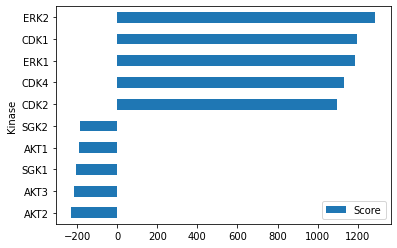

In [ ]:
d.plot.barh()

In [ ]:
# st.to_csv('AKT_kinase.csv',index=False)

In [ ]:
azd.acceptor.value_counts()

s    9757
t    1097
y      70
S       7
T       4
Y       2
Name: acceptor, dtype: int64

In [ ]:
y = get_result(azd,out)

In [ ]:
y.sort_values('change')

,index,up_cnt,dn_cnt,up_weighted_cnt,dn_weighted_cnt,enrich,change
29,EPHA8,0.0,3.0,0.000000000000000,4.121320254189983,-4.121320254189983,-4.121320254189983
31,JAK1,0.0,1.0,0.000000000000000,1.616308532949250,-1.616308532949250,-1.616308532949250
30,FER,0.0,1.0,0.000000000000000,1.616308532949250,-1.616308532949250,-1.616308532949250
28,DDR2,0.0,1.0,0.000000000000000,1.616308532949250,-1.616308532949250,-1.616308532949250
6,EPHA6,2.0,3.0,3.585833322604587,4.121320254189983,-4.121320254189983,-0.535486931585396
23,TNK1,1.0,1.0,1.561695987357824,1.616308532949250,-1.616308532949250,-0.054612545591426
4,EPHA2,1.0,1.0,1.571832444785475,1.367323280906877,1.571832444785475,0.204509163878599
19,PTK2,1.0,1.0,2.176963819770467,1.376998486641553,2.176963819770467,0.799965333128914
2,CSK,1.0,0.0,1.561695987357824,0.000000000000000,1.561695987357824,1.561695987357824
26,WEE1,1.0,0.0,1.831707360544003,0.000000000000000,1.831707360544003,1.831707360544003


In [ ]:
def top_kinases(site_row,top_n=5):
    # Sort the row in descending order and get the top 5 kinases
    top_kinases = site_row.sort_values(ascending=False).head(top_n)
    
    # Get the counts of the top kinases
    kinase_counts = top_kinases.index.value_counts()
    
    return kinase_counts

def get_result(site,site_score,is_Y=True,top_n = 5):
    
    if is_Y:
        idx_up = site.index[(site.acceptor.str.upper()=="Y") & (site['logP']>1.3)]
        idx_dn = site.index[(site.acceptor.str.upper()=="Y") & (site['logP']<-1.3)]
    else:
        idx_up = site.index[(site.acceptor.str.upper()!="Y") & (site['logP']>1.3)]
        idx_dn = site.index[(site.acceptor.str.upper()!="Y") & (site['logP']<-1.3)]
    
    up_site = site.loc[idx_up]
    dn_site = site.loc[idx_dn]

    up_score = site_score.loc[idx_up]
    dn_score = site_score.loc[idx_dn]
    
    func = partial(top_kinases,top_n=top_n)
    
    up_cnt = up_score.apply(func,axis=1)
    dn_cnt = dn_score.apply(func,axis=1)
    
    df_up_cnt = up_cnt.sum().reset_index(name = 'up_cnt')
    df_dn_cnt = dn_cnt.sum().reset_index(name = 'dn_cnt')
    
    df_w_up = up_cnt.multiply(abs(up_site['logP']),axis=0).sum().reset_index(name = 'up_weighted_cnt')
    df_w_dn = dn_cnt.multiply(abs(dn_site['logP']),axis=0).sum().reset_index(name = 'dn_weighted_cnt')
    
    dfs = [df_up_cnt,df_dn_cnt,df_w_up,df_w_dn]
    
    result = reduce(lambda left, right: pd.merge(left, right, how='outer'), dfs)
    
    result = result.fillna(0)
    result['enrich'] = result.apply(lambda r: r.up_weighted_cnt if r.up_weighted_cnt >= r.dn_weighted_cnt else -r.dn_weighted_cnt,axis=1)
    result['change'] = result.up_weighted_cnt - result.dn_weighted_cnt
    
    
    return result